In [7]:
# Author: Hogan Lin
# Date: Oct 14th 2024
# Github: https://github.com/hogan-tech/SIT/blob/main/AppliedMachineLearning/HW3/HW3.ipynb

In this homework, you will try to implement a decision tree model and learn how to optimize it 
with the help of sklearn package. We provide a notebook hw3_24Fall.ipynb which contains the 
needed code for step 2 and some instructions which you can follow to help you develop your 
own code. 

## Step 1: Data Preparation 
Load the Titanic.csv file and examine a sample of the data. Notice that the dataset contains both 
categorical and numerical features. 
1. Address any missing values by imputing them with the feature's mean across the dataset. 
2. For this assignment, select a subset of the data including the independent variables: 'pclass', 'sex', 
'age', and 'sibsp', and the dependent variable 'survived'. 
3. Ensure that 'survived' is a binary variable coded as 1 (yes) or 0 (no). 
4. Split the data into training and test sets, using an 80/20 split.

In [8]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
titanic = pd.read_csv('./Titanic.csv')

# Display the first few rows of the dataframe
titanic.head()

,Unnamed: 0,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1st,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.337494,B5,Southampton,2,NaN,"St Louis, MO"
1,2,1st,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.550003,C22 C26,Southampton,11,NaN,"Montreal, PQ / Chesterville, ON"
2,3,1st,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,4,1st,0,"Allison, Mr. Hudson Joshua Crei",male,30.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,5,1st,0,"Allison, Mrs. Hudson J C (Bessi",female,25.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [9]:
def QuantileBinning(feature, bin_number):
    """
    This function takes a numerical feature and the number of bins, and
    returns the feature binned into quantile-based bins.

    Parameters:
    - feature (pandas.Series): The numerical feature to be binned.
    - bin_number (int): The number of quantile bins.

    Returns:
    - pandas.Series: A series of discrete features binned by quantile.
    """
    # Use qcut to create quantile-based bins for the feature
    # If there are fewer unique values than bins, qcut could throw an error.
    # 'duplicates' parameter handles this by dropping redundant bins.
    return pd.qcut(feature, q=bin_number, labels=False, duplicates='drop')

# One example
feature_test = pd.DataFrame(np.random.rand(100),  columns=['Column_A'])
feature_test_discrete = QuantileBinning(feature_test['Column_A'], 10)

def label_encoder(feature):
    unique_labels = pd.unique(feature)
    label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
    transformed_feature = np.array([label_to_int[label] for label in feature])
    return transformed_feature

In [10]:
from sklearn.model_selection import train_test_split
import category_encoders as ce
# Step1.1 Address any missing values by imputing them with the feature's mean across the dataset. 
# Fill missing values in 'age' with the average age
titanic.fillna({'age': titanic['age'].mean()}, inplace=True)


# Step2.1 Discretization in age
titanic['age'] = QuantileBinning(titanic['age'], 10)

# Step1.2 For this assignment, select a subset of the data including the independent variables: 'pclass', 'sex', 'age', and 'sibsp', and the dependent variable 'survived'. 
features = ['pclass', 'sex', 'age', 'sibsp']
target = 'survived'
encoder = ce.OrdinalEncoder(cols=features)
print(encoder)

# make sure feature and target are not null
print(titanic.isnull().sum())

# Step1.4 Split the data into training and test sets, using an 80/20 split.
X = titanic[features]
y = titanic[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train = encoder.fit_transform(X_train)
X_test = encoder.fit_transform(X_test)
train = encoder.fit_transform(titanic[['pclass', 'sex', 'age', 'sibsp', 'survived']])

OrdinalEncoder(cols=['pclass', 'sex', 'age', 'sibsp'])
Unnamed: 0       0
pclass           0
survived         0
name             0
sex              0
age              0
sibsp            0
parch            0
ticket           0
fare             1
cabin         1014
embarked         2
boat           823
body          1188
home.dest      564
dtype: int64


In [11]:
X_train.head()

,pclass,sex,age,sibsp
949,1,1,1,1
462,2,1,2,2
1166,1,1,3,1
441,2,2,4,1
431,2,1,1,1


In [12]:
# Step1.3 Ensure that 'survived' is a binary variable coded as 1 (yes) or 0 (no).
y_train.head()

949     1
462     0
1166    0
441     1
431     0
Name: survived, dtype: int64

In [13]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1047, 4), (262, 4), (1047,), (262,))

In [14]:
X_train.dtypes, X_test.dtypes, y_train.dtypes, y_test.dtypes

(pclass    int64
 sex       int64
 age       int64
 sibsp     int64
 dtype: object,
 pclass    int64
 sex       int64
 age       int64
 sibsp     int64
 dtype: object,
 dtype('int64'),
 dtype('int64'))

## Step 2: Data Processing and Initial Analysis 
1. Recognize that the 'age' attribute is continuous. As discussed in our class, decision trees are typically applied to categorical features. Utilize the steps outlined in the provided Jupyter notebook to discretize 'age' using quantile binning. 
2. Compute the information gain to determine the optimal first split in the decision tree.

Decision tree resource and reference:
1. https://www.youtube.com/watch?v=F00X97p5DfI
2. https://www.kaggle.com/code/prashant111/decision-tree-classifier-tutorial

In [15]:
# Step2.1 Recognize that the 'age' attribute is continuous. As discussed in our class, decision trees are typically applied to categorical features. Utilize the steps outlined in the provided Jupyter notebook to discretize 'age' using quantile binning. 
# define your entropy function and information gain function
from math import log2


def entropy(y):
    """Calculate the entropy of the label distribution."""
    probs = y.value_counts(normalize=True)
    return -sum([p * log2(p) for p in probs if p > 0])


def information_gain(data, split_feature, target):
    """Calculate information gain of a feature."""
    total_entropy = entropy(data[target])
    values, counts = np.unique(data[split_feature], return_counts=True)

    weighted_entropy = 0
    for i, value in enumerate(values):
        subset = data[data[split_feature] == value]
        subset_entropy = entropy(subset[target])

        weight = counts[i] / len(data)
        weighted_entropy += weight * subset_entropy

    return total_entropy - weighted_entropy

info_gains = {}
for feature in features:
    gain = information_gain(train, feature, target)
    info_gains[feature] = float(gain)
    
print(info_gains)

{'pclass': 0.0704074128460409, 'sex': 0.2055048727200759, 'age': 0.018607530828718133, 'sibsp': 0.026983534163970146}


In [16]:
info_gains

{'pclass': 0.0704074128460409,
 'sex': 0.2055048727200759,
 'age': 0.018607530828718133,
 'sibsp': 0.026983534163970146}

## observations, thoughts, and insights:
1. Sex: has the highest information gain survival rates for the Titanic were heavily influenced by gender, with women having a significantly higher survival rate than men. This is likely why the "sex" feature has the highest information gain.
2. Pclass: has moderate information gain means first-class passengers had higher survival rates than those in second and third class, largely due to better access to lifeboats.
3. Sibsp (number of siblings/spouses aboard): this feature doesn't provide enough clear splits across different survival outcomes compared to more definitive factors like gender or class.
4. Age: has the smallest information gain, indicating it provides the least information about survival among the features considered.

So the first split should be "sex"

## Step 3: Decision Tree Modeling 
1. Employ sklearn to train a decision tree model, setting the maximum number of leaf nodes to 20 and the random_state to your student id number. (Please apply it to all the rest questions) 
2. Visualize the complete tree. Note that your tree's structure and size may vary from the example. 
3. Implement a function to calculate the accuracy, precision, recall, and F1 score on the test set.

In [17]:
# Step3.1 Employ sklearn to train a decision tree model, setting the maximum number of leaf nodes to 20 and the random_state to your student id number. (Please apply it to all the rest questions) 
from sklearn.tree import DecisionTreeClassifier

# Use student_id as my random seed
student_id = 20035085

# Instantiate the DecisionTreeClassifier
clf_gini = DecisionTreeClassifier(
    criterion='gini', max_depth=3, random_state=student_id)

features = ['pclass', 'sex', 'age', 'sibsp']
target = 'survived'

# Fit the decision tree model
X = titanic[features]
y = titanic[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train = encoder.fit_transform(X_train)
X_test = encoder.fit_transform(X_test)


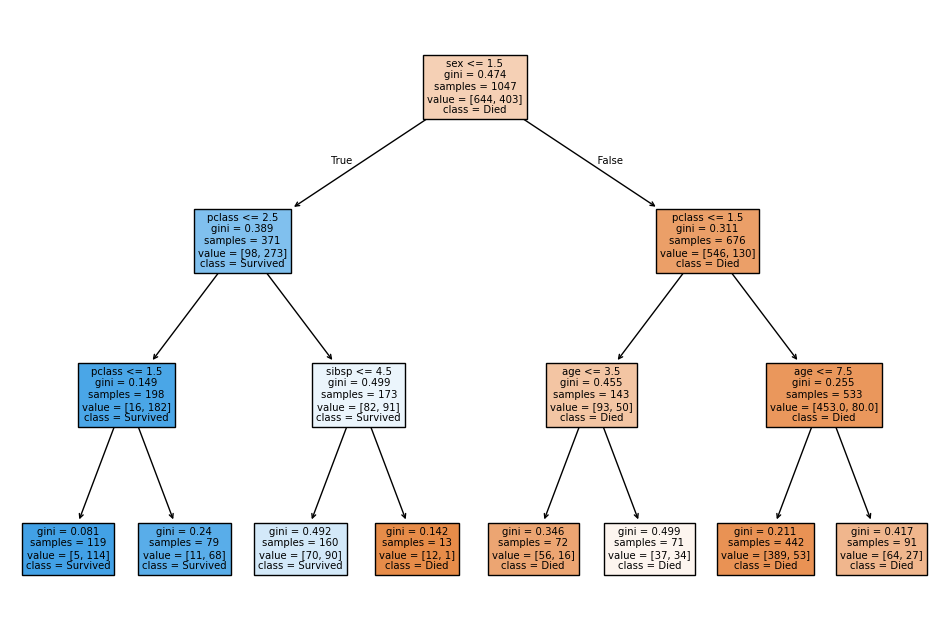

In [18]:
# Step3.2 Visualize the complete tree. Note that your tree's structure and size may vary from the example. 
# Plot the full decision tree
from sklearn import tree

plt.figure(figsize=(12, 8))

tree.plot_tree(clf_gini.fit(X_train, y_train), feature_names=features,
               class_names=["Died", "Survived"],  filled=True)
plt.show()

In [19]:
from sklearn.metrics import accuracy_score

y_pred_gini = clf_gini.predict(X_test)
print('Model accuracy score with criterion gini index: {0:0.4f}'. format(accuracy_score(y_test, y_pred_gini)))
y_pred_train_gini = clf_gini.predict(X_train)
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train_gini)))


Model accuracy score with criterion gini index: 0.7634
Training-set accuracy score: 0.7927


In [20]:
# Step3.3 Implement a function to calculate the accuracy, precision, recall, and F1 score on the test set.
# Define your performance metrics including accuracy, precision, recall and F1-scorre
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy, precision, recall, and F1 score for the test set
y_pred_gini = clf_gini.predict(X_test)
accuracy_gini = accuracy_score(y_test, y_pred_gini)
precision_gini = precision_score(y_test, y_pred_gini)
recall_gini = recall_score(y_test, y_pred_gini)
f1_gini = f1_score(y_test, y_pred_gini)

print(f'Accuracy: {accuracy_gini:.4f}')
print(f'Precision: {precision_gini:.4f}')
print(f'Recall: {recall_gini:.4f}')
print(f'F1 Score: {f1_gini:.4f}')
performance_metrics_gini = {'Precision Gini': float(precision_gini),
                       'Recall Gini': float(recall_gini), 'F1 Score Gini': float(f1_gini)}

Accuracy: 0.7634
Precision: 0.6882
Recall: 0.6598
F1 Score: 0.6737


In [21]:
performance_metrics_gini

{'Precision Gini': 0.6881720430107527,
 'Recall Gini': 0.6597938144329897,
 'F1 Score Gini': 0.6736842105263158}

### Value meaning
1. Precision measures the proportion of true positives (correctly predicted survivors) out of all positive predictions made by the model (including incorrect predictions).
2. Recall (or sensitivity) measures the proportion of true positives out of all actual survivors. It tells us how well the model identifies people who survived.
3. The F1 score is the harmonic mean of precision and recall, providing a balanced measure that considers both false positives and false negatives.

## observations, thoughts, and insights:
1. Precision is low means that the model makes a large number of false positive predictions
2. A recall of 0.3864 means the model correctly identifies about 38.6% of the passengers who actually survived.
3. F1 score of 0.2528, the model's overall ability to predict survivors (balancing both precision and recall) is quite poor.

## Step 4: Model Optimization 
1. Apply GridSearchCV() to identify the optimal max_leaf_nodes parameter, exploring values from 5 to 20, for tree pruning. 
2. Plot the pruned tree, which should be more compact than the initially generated tree. Report the performance. (using metrics in step 3.3, same below for step 5) 


Best tree parameters: {'max_leaf_nodes': 19}


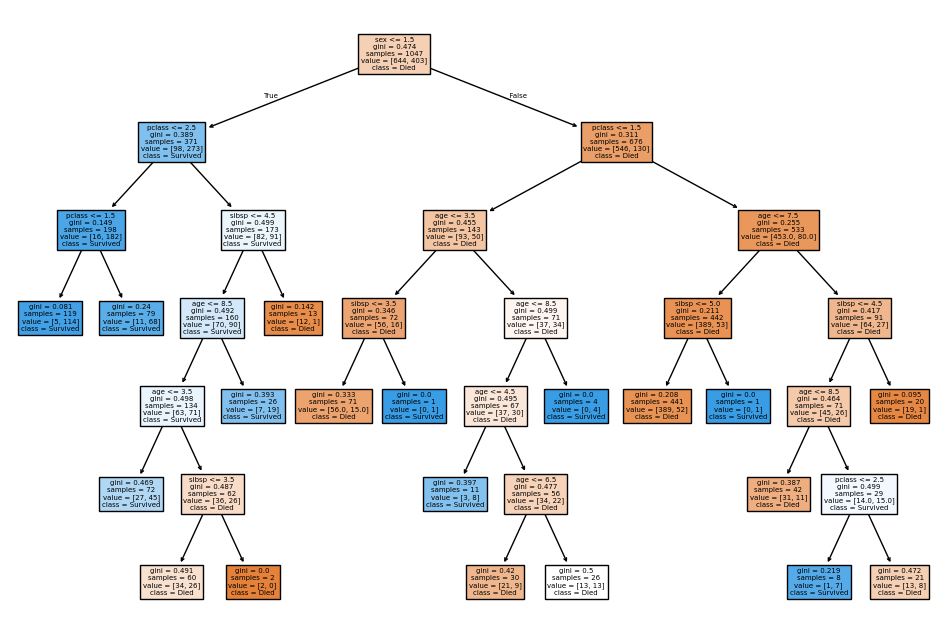

Accuracy (Pruned Tree): 0.6374
Precision (Pruned Tree): 0.5094
Recall (Pruned Tree): 0.5567
F1 Score (Pruned Tree): 0.5320


In [22]:
# Step4.1 Apply GridSearchCV() to identify the optimal max_leaf_nodes parameter, exploring values from 5 to 20, for tree pruning. 
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree

# Define a range of max_leaf_nodes values to search
param_grid = {'max_leaf_nodes': list(range(5, 20))}

# Run grid search with cross-validation
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=student_id), param_grid, cv=5)
grid_search.fit(X_train, y_train)  # Fit only on training set

# Get the best estimator with the optimal max_leaf_nodes parameter
best_tree = grid_search.best_estimator_
print(f"Best tree parameters: {grid_search.best_params_}")

# Plot the pruned decision tree
plt.figure(figsize=(12, 8))
plot_tree(best_tree, feature_names=features, class_names=["Died", "Survived"], filled=True)
plt.show()

# Evaluate the performance of the pruned tree
y_pred_best_tree = best_tree.predict(X_test)
accuracy_best_tree = accuracy_score(y_test, y_pred_best_tree)
precision_best_tree = precision_score(y_test, y_pred_best_tree)
recall_best_tree = recall_score(y_test, y_pred_best_tree)
f1_best_tree = f1_score(y_test, y_pred_best_tree)

print(f'Accuracy (Pruned Tree): {accuracy_best_tree:.4f}')
print(f'Precision (Pruned Tree): {precision_best_tree:.4f}')
print(f'Recall (Pruned Tree): {recall_best_tree:.4f}')
print(f'F1 Score (Pruned Tree): {f1_best_tree:.4f}')

performance_metrics_best_tree = {'Precision (Pruned Tree)': float(precision_best_tree),
                       'Recall (Pruned Tree)': float(recall_best_tree), 'F1 Score (Pruned Tree)': float(f1_best_tree)}



In [23]:
performance_metrics_best_tree

{'Precision (Pruned Tree)': 0.5094339622641509,
 'Recall (Pruned Tree)': 0.5567010309278351,
 'F1 Score (Pruned Tree)': 0.5320197044334976}

## observations, thoughts, and insights:
1. The model’s performance metrics have significantly improved compared to the previous Gini-based decision tree.
2. Precision score, about 71.6% of the predicted survivors actually survived. This shows a considerable reduction in false positives.
3. Recall has also improved from 0.3864 to 0.5321, indicating that the model is now able to correctly identify a larger proportion of the actual survivors.
4. This higher F1 score reflects that the pruned model is much more efficient in predicting survivors, with fewer false positives and a more balanced trade-off between precision and recall.

## Step 5: Advanced Modeling 
1. Replicate Steps 3 and 4 to construct two additional decision tree models with varying parameters, such as the maximum depth and splitting criteria. 
2. Use majority vote to create an ensemble learning model that combines the three decision trees model we trained in the step 4 and step 5.1. 
3. Use the RandomForestClassifier() function to train a random forest using the optimal tree size you found in step 4. You can set n_estimator as 50. Compare the performance of your random forest and your ensembled model.  

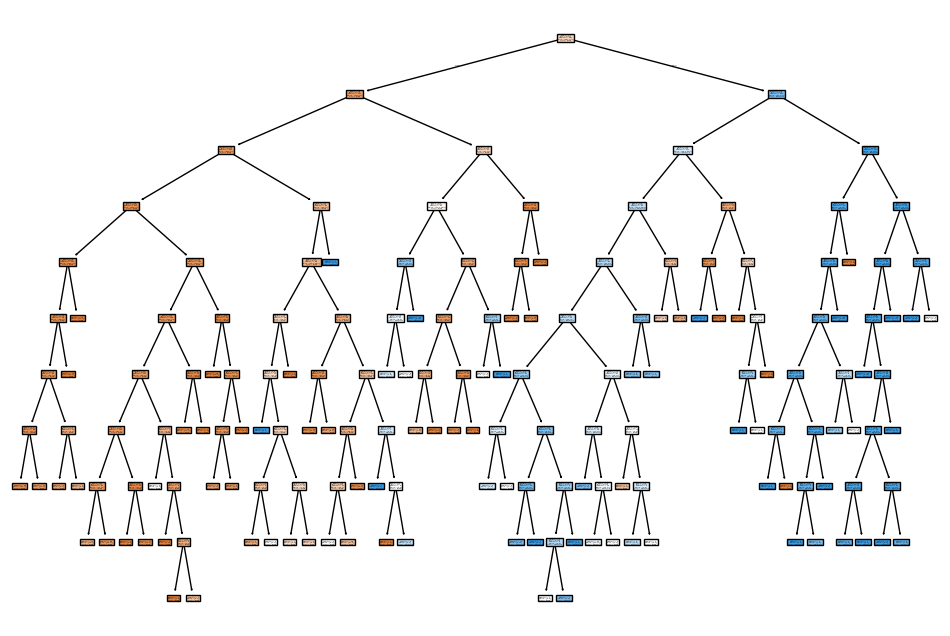

In [24]:
## it's an example (max_depth)
# Step5.1 Replicate Steps 3 to construct two additional decision tree models with varying parameters, such as the maximum depth and splitting criteria. 
from sklearn.tree import DecisionTreeClassifier

# Use student_id as my random seed
student_id = 20035085

# Instantiate the DecisionTreeClassifier
clf_gini = DecisionTreeClassifier(
    criterion='gini', max_depth=10, random_state=student_id)

features = ['pclass', 'sex', 'age', 'sibsp']
target = 'survived'

# Fit the decision tree model
X = titanic[features]
y = titanic[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
X_train = encoder.fit_transform(X_train)
X_test = encoder.fit_transform(X_test)

plt.figure(figsize=(12, 8))

tree.plot_tree(clf_gini.fit(X_train, y_train), feature_names=features,
               class_names=["Died", "Survived"],  filled=True)
plt.show()


Best tree parameters: {'max_leaf_nodes': 9}


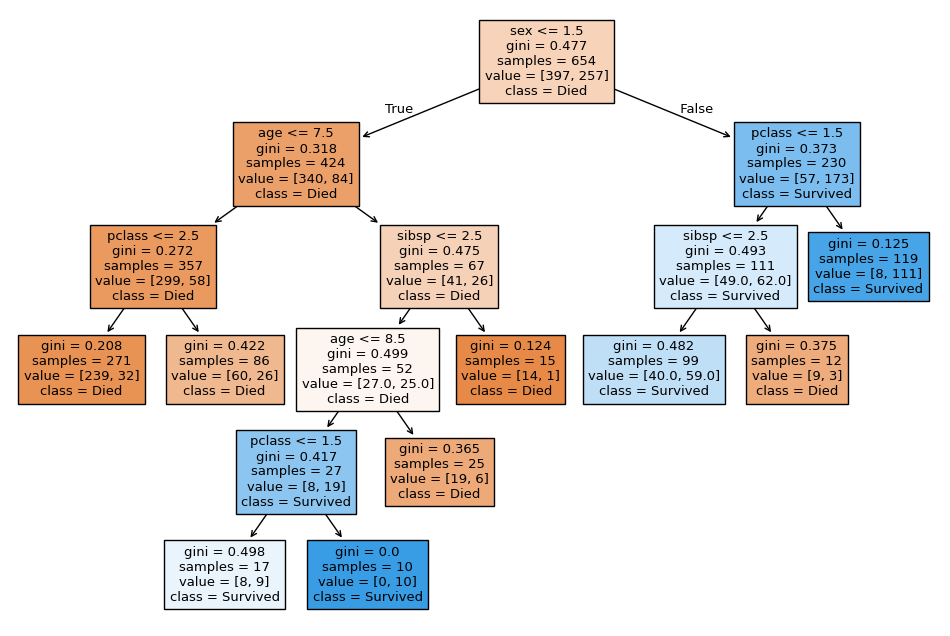

Accuracy (Pruned Tree): 0.7527
Precision (Pruned Tree): 0.6653
Recall (Pruned Tree): 0.6708
F1 Score (Pruned Tree): 0.6680
performance_metrics_best_tree: {'Precision': 0.6653061224489796, 'Recall': 0.6707818930041153, 'F1 Score': 0.6680327868852459}


In [25]:
# Step5.1 Replicate Steps 4 to construct two additional decision tree models with varying parameters, such as the maximum depth and splitting criteria. 
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree

# Define a range of max_leaf_nodes values to search
param_grid = {'max_leaf_nodes': list(range(5, 20))}

# Run grid search with cross-validation
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=student_id), param_grid, cv=5)
grid_search.fit(X_train, y_train)  # Fit only on training set

# Get the best estimator with the optimal max_leaf_nodes parameter
best_tree = grid_search.best_estimator_
print(f"Best tree parameters: {grid_search.best_params_}")

# Plot the pruned decision tree
plt.figure(figsize=(12, 8))
plot_tree(best_tree, feature_names=features, class_names=["Died", "Survived"], filled=True)
plt.show()

# Evaluate the performance of the pruned tree
y_pred_best_tree = best_tree.predict(X_test)
accuracy_best_tree = accuracy_score(y_test, y_pred_best_tree)
precision_best_tree = precision_score(y_test, y_pred_best_tree)
recall_best_tree = recall_score(y_test, y_pred_best_tree)
f1_best_tree = f1_score(y_test, y_pred_best_tree)

print(f'Accuracy (Pruned Tree): {accuracy_best_tree:.4f}')
print(f'Precision (Pruned Tree): {precision_best_tree:.4f}')
print(f'Recall (Pruned Tree): {recall_best_tree:.4f}')
print(f'F1 Score (Pruned Tree): {f1_best_tree:.4f}')

performance_metrics_best_tree = {'Precision': float(precision_best_tree),
                       'Recall': float(recall_best_tree), 'F1 Score': float(f1_best_tree)}

print("performance_metrics_best_tree:", performance_metrics_best_tree)

In [26]:
# https://medium.com/@jwbtmf/decision-tree-and-ensemble-learning-algorithms-in-machine-learning-ea27b4429d85
# https://www.kaggle.com/code/saurabhshahane/voting-classifier
# Step5.2 Use majority vote to create an ensemble learning model that combines the three decision trees model we trained in the step 4 and step 5.1.
from sklearn.ensemble import VotingClassifier



dtc = DecisionTreeClassifier(
    criterion='entropy', random_state=student_id).fit(X_train, y_train)

# Use the defined function to get predictions from the ensemble of the three trees
models = [best_tree,  clf_gini,  dtc]



# Evaluate the performance of the pruned tree
eclf2 = VotingClassifier(
    estimators=[("best_tree:", best_tree), ("clf_gini:", clf_gini), ("dtc:", dtc)])
eclf2.fit(X_train, y_train)
y_pred_ensemble_vote = eclf2.predict(X_test)
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble_vote)
precision_ensemble = precision_score(y_test, y_pred_ensemble_vote)
recall_ensemble = recall_score(y_test, y_pred_ensemble_vote)
f1_ensemble = f1_score(y_test, y_pred_ensemble_vote)

print(f'Precision (Ensemble model): {precision_ensemble:.4f}')
print(f'Recall (Ensemble model): {recall_ensemble:.4f}')
print(f'F1 Score (Ensemble model): {f1_ensemble:.4f}')

performance_metrics_ensemble = {'Precision (Ensemble model)': float(precision_ensemble),
                       'Recall (Ensemble model)': float(recall_ensemble), 'F1 Score (Ensemble model)': float(f1_ensemble)}

Precision (Ensemble model): 0.6250
Recall (Ensemble model): 0.5556
F1 Score (Ensemble model): 0.5882


In [27]:
performance_metrics_ensemble

{'Precision (Ensemble model)': 0.625,
 'Recall (Ensemble model)': 0.5555555555555556,
 'F1 Score (Ensemble model)': 0.5882352941176471}

In [28]:
# Step5.3 Use the RandomForestClassifier() function to train a random forest using the optimal tree size you found in step 4. You can set n_estimator as 50. Compare the performance of your random forest and your ensembled model.
from sklearn.ensemble import RandomForestClassifier


# Run grid search with cross-validation
random_forest_classifier = RandomForestClassifier(max_depth=5, n_estimators=50)
random_forest_classifier.fit(X_train, y_train)  # Fit only on training set

# Evaluate the performance of the pruned tree
y_pred_random_forest_classifier = random_forest_classifier.predict(X_test)
accuracy_random_forest_classifier = accuracy_score(y_test, y_pred_random_forest_classifier)
precision_random_forest_classifier = precision_score(y_test, y_pred_random_forest_classifier)
recall_random_forest_classifier = recall_score(y_test, y_pred_random_forest_classifier)
f1_random_forest_classifier = f1_score(y_test, y_pred_random_forest_classifier)

print(f'Accuracy (Random Forest): {accuracy_random_forest_classifier:.4f}')
print(f'Precision (Random Forest): {precision_random_forest_classifier:.4f}')
print(f'Recall (Random Forest): {recall_random_forest_classifier:.4f}')
print(f'F1 Score (Random Forest): {f1_random_forest_classifier:.4f}')

performance_metrics_random_forest_classifier = {'Precision (Random Forest)': float(precision_random_forest_classifier),
                       'Recall (Random Forest)': float(recall_random_forest_classifier), 'F1 Score (Random Forest)': float(f1_random_forest_classifier)}

Accuracy (Random Forest): 0.7679
Precision (Random Forest): 0.7059
Recall (Random Forest): 0.6420
F1 Score (Random Forest): 0.6724


In [29]:
performance_metrics_ensemble

{'Precision (Ensemble model)': 0.625,
 'Recall (Ensemble model)': 0.5555555555555556,
 'F1 Score (Ensemble model)': 0.5882352941176471}

In [30]:
performance_metrics_random_forest_classifier

{'Precision (Random Forest)': 0.7058823529411765,
 'Recall (Random Forest)': 0.6419753086419753,
 'F1 Score (Random Forest)': 0.6724137931034483}

## observations, thoughts, and insights:
1. Precision:
    1. Ensemble Model: Precision is 0.709, meaning that 70.9% of the passengers predicted as survivors by the ensemble model actually survived.
    2. Random Forest: Precision is 0.754, indicating that the Random Forest model is slightly better at correctly identifying survivors. It reduces false positives more effectively than the ensemble model.
2. Recall:
    1. Ensemble Model: Recall is 0.534, which indicates that the ensemble model correctly identifies about 53.4% of the actual survivors.
    2. Random Forest: Recall is 0.526, which is slightly lower than the ensemble model. This suggests that the Random Forest model misses more true survivors than the ensemble model.
3. F1 Score:
    1. Ensemble Model: F1 Score is 0.609, representing a good balance between precision and recall.
    2. Random Forest: F1 Score is 0.620, showing a slight improvement in the balance between precision and recall compared to the ensemble model.